<a href="https://colab.research.google.com/github/emanuelebrizzi/bootcamp/blob/main/code_vulnerability_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal is to do code vulnerability detection using deep learning techniques. For this purpose, I utilized data available at https://github.com/Seahymn2019/Function-level-Vulnerability-Dataset/blob/master/Vulnerable%20Functions%20Statistical%20Analysis.md, which includes code from three distinct open-source projects: LibPNG, Pidgin and VLC.

# **Data upload**


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import os
import glob

# Directory path
drive_path = "/content/drive/MyDrive/bootcamp_file"

libpng_path = os.path.join(drive_path, "LibPNG")

libpng_vuln_path = os.path.join(libpng_path, "Vulnerable_functions")
libpng_non_vuln_path = os.path.join(libpng_path, "Non_vulnerable_functions")

vlc_path = os.path.join(drive_path, "VLC")

vlc_vuln_path = os.path.join(vlc_path, "Vulnerable_functions")
vlc_non_vuln_path = os.path.join(vlc_path, "Non_vulnerable_functions")

pidgin_path = os.path.join(drive_path, "Pidgin")

pidgin_vuln_path = os.path.join(pidgin_path, "Vulnerable_functions")
pidgin_non_vuln_path = os.path.join(pidgin_path, "Non_vulnerable_functions")


In [4]:

def load_files_from_folder(folder, label):
    files = glob.glob(os.path.join(folder, "*.c"))
    data = []
    for file in files:
        with open(file, "r", encoding="utf-8", errors="ignore") as f:
            data.append((f.read(), label, os.path.basename(file)))
    return data


# **Replace Function names and Variable names**

Removing comments inside code files.

Replacing of function and variable names with generic or unified identifiers. This transformation helps reduce the superficial variability of the source code, making it easier to detect vulnerability patterns that might be obscured by specific names.

In [5]:
import re
import random
import string
from pathlib import Path

In [6]:
# Removes comments from C code
def remove_comments(code):
    code = re.sub(r'//.*', '', code)
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
    return code

# Extracts variable and function names from C code
def extract_identifiers(code):
    pattern = re.compile(r'\b([a-zA-Z_][a-zA-Z0-9_]*)\b')
    keywords = set(['int', 'char', 'float', 'double', 'return', 'if', 'else', 'while', 'for', 'do', 'switch', 'case', 'void'])
    identifiers = set(pattern.findall(code)) - keywords
    return identifiers

# Classifies identifiers as variables or functions
def categorize_identifiers(identifiers):
    var_counter, fun_counter = 1, 1
    replacements = {}
    for identifier in identifiers:
        if re.search(r'\b[A-Za-z_][A-Za-z0-9_]*\s*\(', identifier):
            replacements[identifier] = f'fun_{fun_counter}'
            fun_counter += 1
        else:
            replacements[identifier] = f'var_{var_counter}'
            var_counter += 1
    return replacements

# Replaces variable and function names with new names
def replace_identifiers(code, replacements):

    for old, new in replacements.items():
        code = re.sub(r'\b' + re.escape(old) + r'\b', new, code)
    return code

# Reads a C file, replaces names, and saves the new file
def process_c_file(filepath, new_filepath):
    with open(filepath, 'r', encoding='Latin-1') as file:
        code = file.read()

    code_no_comments = remove_comments(code)
    identifiers = extract_identifiers(code_no_comments)
    replacements = categorize_identifiers(identifiers)
    new_code = replace_identifiers(code_no_comments, replacements)
    with open(new_filepath, 'w', encoding='Latin-1') as file:
        file.write(new_code)

# Processes all C files in a directory
def process_directory(directory, new_directory_path):
    for filepath in Path(directory).glob("*.c"):
        new_filepath = os.path.join(new_directory_path, os.path.basename(filepath))
        process_c_file(filepath, new_filepath)

In [7]:
import shutil

def create_directory(directory_path):
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
    os.makedirs(directory_path, exist_ok=True)

# Creation modified directory
modified_path = os.path.join(drive_path, "modified_files")
create_directory(modified_path)

libpng_modified = os.path.join(modified_path, "LibPNG")
create_directory(libpng_modified)

vlc_modified = os.path.join(modified_path, "VLC")
create_directory(vlc_modified)

pidgin_modified = os.path.join(modified_path, "Pidgin")
create_directory(pidgin_modified)

libpng_modified_vuln_path = os.path.join(libpng_modified, "Vulnerable_functions")
create_directory(libpng_modified_vuln_path)
libpng_modified_non_vuln_path = os.path.join(libpng_modified, "Non_vulnerable_functions")
create_directory(libpng_modified_non_vuln_path)

vlc_modified_vuln_path = os.path.join(vlc_modified, "Vulnerable_functions")
create_directory(vlc_modified_vuln_path)
vlc_modified_non_vuln_path = os.path.join(vlc_modified, "Non_vulnerable_functions")
create_directory(vlc_modified_non_vuln_path)

pidgin_modified_vuln_path = os.path.join(pidgin_modified, "Vulnerable_functions")
create_directory(pidgin_modified_vuln_path)
pidgin_modified_non_vuln_path = os.path.join(pidgin_modified, "Non_vulnerable_functions")
create_directory(pidgin_modified_non_vuln_path)

In [ ]:
process_directory(libpng_vuln_path, libpng_modified_vuln_path)
process_directory(libpng_non_vuln_path, libpng_modified_non_vuln_path)
process_directory(vlc_vuln_path, vlc_modified_vuln_path)
process_directory(vlc_non_vuln_path, vlc_modified_non_vuln_path)
process_directory(pidgin_vuln_path, pidgin_modified_vuln_path)
process_directory(pidgin_non_vuln_path, pidgin_modified_non_vuln_path)

# Dataset preparation

In [8]:
import os
import numpy as np
from collections import Counter
from tabulate import tabulate
import random
import os
import re

In [10]:
# Load and label data
def load_data_directoies(directories, label):
    data = []
    for directory in directories:  # Iteriamo sulle directory della lista
        for filename in os.listdir(directory):  # Ora directory è una stringa
            with open(os.path.join(directory, filename), 'r') as file:
                data.append((file.read(), label))
    return data
vulnerable_files = load_data_directoies([libpng_modified_vuln_path, vlc_modified_vuln_path, pidgin_modified_vuln_path], label=1)
non_vulnerable_files = load_data_directoies([libpng_modified_non_vuln_path, vlc_modified_non_vuln_path, pidgin_modified_non_vuln_path], label=0)

# Combine and shuffle dataset
dataset = vulnerable_files + non_vulnerable_files
np.random.shuffle(dataset)

texts, labels = zip(*dataset)

### Dataset info

In [11]:
print("Vulnerable files: ", len(vulnerable_files))
print("Non Vulnerable files: ", len(non_vulnerable_files))
print("Dataset files: ", len(dataset))

Vulnerable files:  118
Non Vulnerable files:  15318
Dataset files:  15436


In [12]:
n = len(vulnerable_files) * 8

non_vulnerable_files_selected = random.sample(non_vulnerable_files, min(n, len(non_vulnerable_files)))

dataset = vulnerable_files + non_vulnerable_files_selected
random.shuffle(dataset)

texts, labels = zip(*dataset)


In [13]:
print("Vulnerable files: ", len(vulnerable_files))
print("Non Vulnerable files: ", len(non_vulnerable_files_selected))
print("Dataset files: ", len(dataset))

Vulnerable files:  118
Non Vulnerable files:  944
Dataset files:  1062


# Models

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GRU


In [15]:
# Tokenize the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

In [16]:
max_length = 500  # Adjust based on dataset
data = pad_sequences(sequences, maxlen=max_length, padding='post')
labels = np.array(labels)

In [17]:
# Split dataset into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [18]:
embedding_dim = 128
batch_size = 32
epochs = 5

BLSTM Model

In [19]:
# Model Creation
blstm_model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.1)),
    Dense(1, activation='sigmoid')
])

blstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train BLSTM model
print("Training BLSTM Model...")
blstm_history = blstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

# Evaluate BLSTM model
blstm_loss, blstm_accuracy = blstm_model.evaluate(X_test, y_test)
print(f"BLSTM Test Loss: {blstm_loss}")
print(f"BLSTM Test Accuracy: {blstm_accuracy}")

# Predict using BLSTM model
blstm_predictions = blstm_model.predict(X_test)
blstm_y_pred = (blstm_predictions > 0.5).astype(int)

Training BLSTM Model...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7606 - loss: 0.4978 - val_accuracy: 0.8732 - val_loss: 0.4126
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8964 - loss: 0.3065 - val_accuracy: 0.8732 - val_loss: 0.3624
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 957ms/step - accuracy: 0.8858 - loss: 0.3219 - val_accuracy: 0.8732 - val_loss: 0.3687
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8920 - loss: 0.3027 - val_accuracy: 0.8732 - val_loss: 0.3664
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8954 - loss: 0.2848 - val_accuracy: 0.8779 - val_loss: 0.3561
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.8791 - loss: 0.3512
BLSTM Test Loss: 0.35601451992988586
BLSTM Test Accuracy: 0.8779342770576477
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step


GRU Model

In [20]:
# GRU Model Creation
gru_model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_length),
    GRU(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.1),
    Dense(1, activation='sigmoid')
])

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train GRU model
print("Training GRU Model...")
gru_history = gru_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

# Evaluate GRU model
gru_loss, gru_accuracy = gru_model.evaluate(X_test, y_test)
print(f"GRU Test Loss: {gru_loss}")
print(f"GRU Test Accuracy: {gru_accuracy}")

# Predict using GRU model
gru_predictions = gru_model.predict(X_test)
gru_y_pred = (gru_predictions > 0.5).astype(int)

Training GRU Model...
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 567ms/step - accuracy: 0.8178 - loss: 0.5075 - val_accuracy: 0.8732 - val_loss: 0.3907
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 609ms/step - accuracy: 0.9057 - loss: 0.2993 - val_accuracy: 0.8732 - val_loss: 0.3763
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 577ms/step - accuracy: 0.8942 - loss: 0.3019 - val_accuracy: 0.8685 - val_loss: 0.3838
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 567ms/step - accuracy: 0.9169 - loss: 0.2574 - val_accuracy: 0.8732 - val_loss: 0.3776
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 448ms/step - accuracy: 0.9070 - loss: 0.2935 - val_accuracy: 0.8732 - val_loss: 0.3807
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8693 - loss: 0.3555
GRU Test Loss: 0.3590960204601288
GRU Test Accuracy: 0.8685445785522461
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step


### Comparison

In [21]:
import matplotlib.pyplot as plt

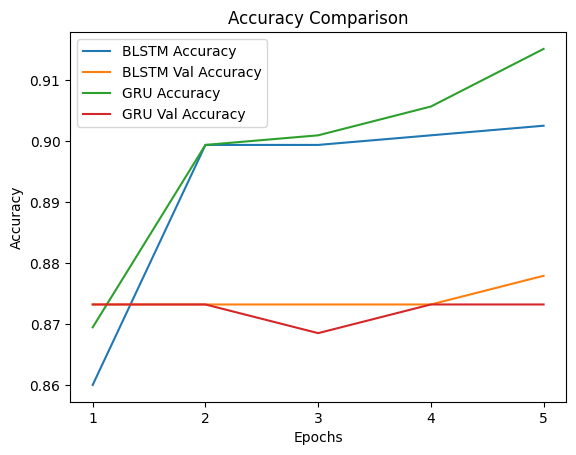

In [38]:
# Accuracy comparison
plt.plot(blstm_history.history['accuracy'], label='BLSTM Accuracy')
plt.plot(blstm_history.history['val_accuracy'], label='BLSTM Val Accuracy')
plt.plot(gru_history.history['accuracy'], label='GRU Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='GRU Val Accuracy')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(ticks=range(0, epochs), labels=range(1, epochs + 1))
plt.legend()
plt.show()


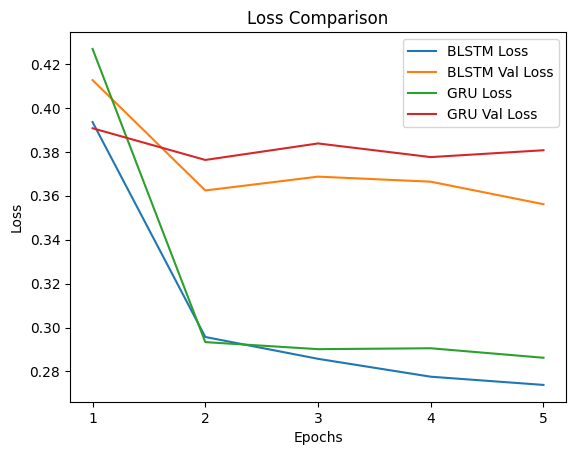

In [39]:
# Loss comparison
plt.plot(blstm_history.history['loss'], label='BLSTM Loss')
plt.plot(blstm_history.history['val_loss'], label='BLSTM Val Loss')
plt.plot(gru_history.history['loss'], label='GRU Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Val Loss')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(ticks=range(0, epochs), labels=range(1, epochs + 1))
plt.legend()
plt.show()

## **Cross Validation** with K-Fold

In [24]:
from sklearn.model_selection import KFold

# Define K-Fold Cross-Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

embedding_dim = 128
batch_size = 32
epochs = 5

folds_indices = list(kf.split(data))

In [25]:
blstm_accuracies = []
blstm_losses = []

for fold, (train_index, test_index) in enumerate(folds_indices):
    print(f"Training on Fold {fold+1}/{k_folds}...")

    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Model Creation
    blstm_model = Sequential([
        Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_length),
        Bidirectional(LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.1)),
        Dense(1, activation='sigmoid')
    ])


    blstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    blstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

    blstm_loss, blstm_accuracy = blstm_model.evaluate(X_test, y_test, verbose=0)
    blstm_accuracies.append(blstm_accuracy)
    blstm_losses.append(blstm_loss)
    print(f"BLSTM Fold {fold+1} - Test Loss: {blstm_loss:.4f}, Test Accuracy: {blstm_accuracy:.4f}")

print(f"Average Accuracy: {np.mean(blstm_accuracies)}")





Training on Fold 1/5...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8793 - loss: 0.4786 - val_accuracy: 0.9118 - val_loss: 0.3096
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8952 - loss: 0.3066 - val_accuracy: 0.9118 - val_loss: 0.3039
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 920ms/step - accuracy: 0.9099 - loss: 0.2701 - val_accuracy: 0.9059 - val_loss: 0.3064
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9163 - loss: 0.2873 - val_accuracy: 0.9059 - val_loss: 0.2998
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9099 - loss: 0.2689 - val_accuracy: 0.8765 - val_loss: 0.2986
BLSTM Fold 1 - Test Loss: 0.3471, Test Accuracy: 0.8451
Training on Fold 2/5...
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8600 - loss: 0.4847 - val_accuracy: 0.8941 - val_loss: 0.3441
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 957ms/step - accuracy: 0.8861 - loss: 0.3152 - val_accuracy: 0.8941 - val_loss: 0.3436
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step 

In [26]:
gru_accuracies = []
gru_losses = []

for fold, (train_index, test_index) in enumerate(folds_indices):
    print(f"Training on Fold {fold+1}/{k_folds}...")

    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    print(f"\nTraining GRU Model on Fold {fold+1}...")
    gru_model = Sequential([
        Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_length),
        GRU(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.1),
        Dense(1, activation='sigmoid')
    ])

    gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    gru_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

    gru_loss, gru_accuracy = gru_model.evaluate(X_test, y_test, verbose=0)
    gru_accuracies.append(gru_accuracy)
    gru_losses.append(gru_loss)
    print(f"GRU Fold {fold+1} - Test Loss: {gru_loss:.4f}, Test Accuracy: {gru_accuracy:.4f}")

print(f"Average Accuracy: {np.mean(gru_accuracies)}")



Training on Fold 1/5...

Training GRU Model on Fold 1...
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 619ms/step - accuracy: 0.7675 - loss: 0.5188 - val_accuracy: 0.9118 - val_loss: 0.3379
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 770ms/step - accuracy: 0.8917 - loss: 0.3283 - val_accuracy: 0.9118 - val_loss: 0.3141
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 615ms/step - accuracy: 0.8851 - loss: 0.3416 - val_accuracy: 0.9118 - val_loss: 0.3156
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 649ms/step - accuracy: 0.8955 - loss: 0.3177 - val_accuracy: 0.9059 - val_loss: 0.3149
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 580ms/step - accuracy: 0.9074 - loss: 0.3036 - val_accuracy: 0.9059 - val_loss: 0.3147
GRU Fold 1 - Test Loss: 0.3565, Test Accuracy: 0.8732
Training on Fold 2/5...

Training GRU Model on Fold 2...
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 707ms/step - accuracy: 0.8208 - loss: 0.5255 - val_accuracy: 0.8941 - val_loss: 0.3591
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 648ms/step - accuracy: 

### Comparison

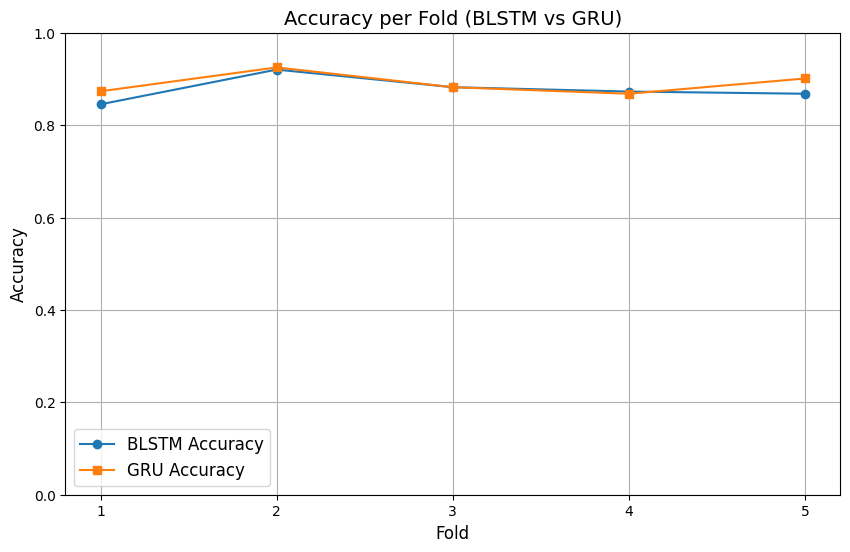

In [27]:
# Plot accuracy for each fold
folds = range(1, k_folds + 1)

plt.figure(figsize=(10, 6))
plt.plot(folds, blstm_accuracies, marker='o', label='BLSTM Accuracy')
plt.plot(folds, gru_accuracies, marker='s', label='GRU Accuracy')

plt.title('Accuracy per Fold (BLSTM vs GRU)', fontsize=14)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(folds)  # Ensure x-axis has integer fold numbers
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


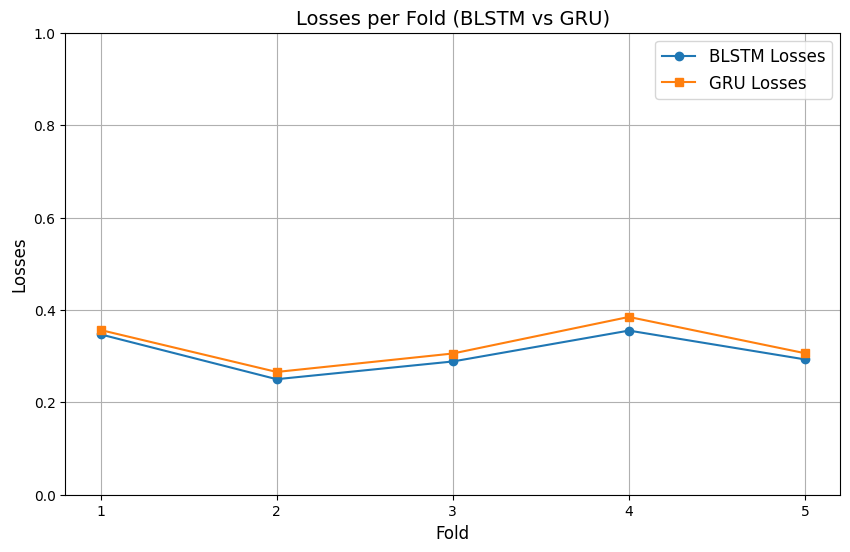

In [28]:
# Plot Losses for each fold
folds = range(1, k_folds + 1)

plt.figure(figsize=(10, 6))
plt.plot(folds, blstm_losses, marker='o', label='BLSTM Losses')
plt.plot(folds, gru_losses, marker='s', label='GRU Losses')

plt.title('Losses per Fold (BLSTM vs GRU)', fontsize=14)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Losses', fontsize=12)
plt.xticks(folds)  # Ensure x-axis has integer fold numbers
plt.ylim(0, 1)  # Losses ranges from 0 to 1
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


## CVE Details for multi label classification

 Files containing vulnerable code are named using their corresponding CVE ID. Information about the CVEs is retrieved by sending requests to the NDV (National Vulnerability Database - https://www.google.com/url?q=https%3A%2F%2Fnvd.nist.gov%2Fdevelopers%2Fvulnerabilities ) through its API.

 Vulnerabilities can be classified in:
 * CVSS:
  * **Low**: CVSS score from 0.0 to 3.9
  * **Medium**: CVSS score from 4.0 to 6.9
  * **High**: CVSS score from 7.0 to 8.9
  * **Critical**: CVSS score from 9.0 to 10.0

* CWE

In [29]:
cve_files = []

directories = [libpng_modified_vuln_path, vlc_modified_vuln_path, pidgin_modified_vuln_path]

pattern = re.compile(r"(?i)(?:^|_)cve-(\d{4})-(\d{4,5})")
# Scan each directory
for directory in directories:
  for file in os.listdir(directory):
    # Search in the file name
    match = pattern.search(file)
    if match:
        formatted_name = f"CVE-{match.group(1)}-{match.group(2)}"
        cve_files.append(formatted_name)


print(f"Vulnerable files: (CVE): {len(cve_files)}")

occurrences = Counter(cve_files)
table_data = [(cve, count) for cve, count in occurrences.items()]
print(tabulate(table_data, headers=["CVE", "Occorrenze"], tablefmt="grid"))


Vulnerable files: (CVE)  118
+----------------+--------------+
| CVE            |   Occorrenze |
+================+==============+
| CVE-2015-0973  |            1 |
+----------------+--------------+
| CVE-2004-0599  |            2 |
+----------------+--------------+
| CVE-2014-9495  |            1 |
+----------------+--------------+
| CVE-2011-3464  |            1 |
+----------------+--------------+
| CVE-2011-0408  |            2 |
+----------------+--------------+
| CVE-2004-0597  |            3 |
+----------------+--------------+
| CVE-2007-2445  |            1 |
+----------------+--------------+
| CVE-2006-0481  |            1 |
+----------------+--------------+
| CVE-2012-3425  |            1 |
+----------------+--------------+
| CVE-2008-5907  |            1 |
+----------------+--------------+
| CVE-2018-13785 |            1 |
+----------------+--------------+
| CVE-2011-3328  |            1 |
+----------------+--------------+
| CVE-2007-5269  |            2 |
+----------------+-

In [34]:
import requests
import time

def get_cve_details(cve_id):
    # URL to obtain vulnerability details from the NVD in JSON format
    url = f'https://services.nvd.nist.gov/rest/json/cves/2.0/?cveId={cve_id}'

    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data
    elif response.status_code == 403:
        time.sleep(30)
        return get_cve_details(cve_id)
    else:
        print(f"Error fetching data for {cve_id}: {response.status_code}")
        return None

In [41]:
def get_cve_cvss_cwe(cve_id):
    data_cve = get_cve_details(cve_id)
    if data_cve is None:
        return None
    try:
      cvss_score = data_cve["vulnerabilities"][0]["cve"]["metrics"]["cvssMetricV2"][0]["cvssData"]["baseScore"]
    except KeyError:
      print(f"CVSS score not found for {cve_id}")
      cvss_score = None
    try:
      cvss_severity = data_cve["vulnerabilities"][0]["cve"]["metrics"]["cvssMetricV2"][0]["baseSeverity"]
    except KeyError:
      print(f"CVSS severity not found for {cve_id}")
      cvss_severity = None
    try:
      cwe_value = data_cve["vulnerabilities"][0]["cve"]["weaknesses"][0]["description"][0]["value"]
    except KeyError:
      print(f"CWE not found for {cve_id}")
      cwe_value = None
    return cvss_score, cvss_severity, cwe_value

cvss = []
severity = []
cwe = []

for cve in cve_files:
    cve_cvss, cve_severity, cve_cwe = get_cve_cvss_cwe(cve)
    print(f"{cve}: CVSS Score = {cve_cvss} Severity = {cve_severity}, CWE = {cve_cwe}")
    cvss.append(cve_cvss)
    severity.append(cve_severity)
    cwe.append(cve_cwe)


CVE-2015-0973: CVSS Score = 7.5 Severity = HIGH, CWE = CWE-119
CVE-2004-0599: CVSS Score = 5.0 Severity = MEDIUM, CWE = NVD-CWE-Other
CVE-2014-9495: CVSS Score = 10.0 Severity = HIGH, CWE = CWE-119
CVE-2011-3464: CVSS Score = 7.5 Severity = HIGH, CWE = CWE-189
CVE-2011-0408: CVSS Score = 6.8 Severity = MEDIUM, CWE = CWE-119
CVE-2004-0597: CVSS Score = 10.0 Severity = HIGH, CWE = NVD-CWE-Other
CVE-2004-0597: CVSS Score = 10.0 Severity = HIGH, CWE = NVD-CWE-Other
CVE-2007-2445: CVSS Score = 5.0 Severity = MEDIUM, CWE = NVD-CWE-noinfo
CVE-2006-0481: CVSS Score = 5.0 Severity = MEDIUM, CWE = CWE-119
CVE-2012-3425: CVSS Score = 4.3 Severity = MEDIUM, CWE = CWE-119
CVE-2008-5907: CVSS Score = 5.0 Severity = MEDIUM, CWE = NVD-CWE-noinfo
CVE-2018-13785: CVSS Score = 4.3 Severity = MEDIUM, CWE = CWE-190
CVE-2004-0599: CVSS Score = 5.0 Severity = MEDIUM, CWE = NVD-CWE-Other
CVE-2011-3328: CVSS Score = 2.6 Severity = LOW, CWE = NVD-CWE-Other
CVE-2007-5269: CVSS Score = 5.0 Severity = MEDIUM, CWE 

In [58]:
title = ["CVE", "CVSS", "Severity", "CWE"]
cves_info = np.vstack([title, np.column_stack([cve_files, cvss, severity, cwe])])
np.savetxt(f"{drive_path}/cves_info.csv", cves_info, delimiter=",", fmt="%s")

In [67]:
column_index = title.index("Severity")
severity_column = cves_info[1:, column_index]
occurrences = Counter(severity_column)
print(f"Severity: {occurrences}")

Severity: Counter({'MEDIUM': 82, 'HIGH': 34, 'LOW': 2})


In [68]:
column_index = title.index("CWE")
cwe_column = cves_info[1:, column_index]
occurrences = Counter(cwe_column)
print(f"CWE: {occurrences}")

CWE: Counter({'CWE-119': 35, 'CWE-189': 21, 'NVD-CWE-Other': 13, 'CWE-20': 10, 'CWE-399': 8, 'CWE-125': 7, 'NVD-CWE-noinfo': 4, 'CWE-134': 3, 'CWE-190': 2, 'CWE-120': 2, 'CWE-79': 2, 'CWE-200': 2, 'CWE-824': 2, 'CWE-476': 1, 'CWE-401': 1, 'CWE-400': 1, 'CWE-416': 1, 'CWE-22': 1, 'CWE-787': 1, 'CWE-264': 1})


## Dataset preparation